# Normal Distribution MLE Parameter Estimation Simulation

This notebook simulates normal distributions (1D and 5D), estimates parameters using Maximum Likelihood Estimation (MLE), and compares theoretical vs. simulated parameter uncertainties.

## Objectives:
1. Simulate 1D and 5D normal distributions with n samples
2. Estimate μ and σ using MLE
3. Repeat simulation K times
4. Compare theoretical and simulated parameter uncertainties


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# IMPORTANT: MLE Bias Issue
def mle_normal_1d_unbiased(data: np.ndarray) -> Tuple[float, float]:
    """
    Unbiased estimators for 1D normal distribution.
    Uses n-1 in denominator for variance (sample variance).
    """
    n = len(data)
    mu_hat = np.mean(data)
    sigma_hat = np.sqrt(np.sum((data - mu_hat)**2) / (n - 1))  # Unbiased: uses n-1
    return mu_hat, sigma_hat

def mle_normal_multivariate_unbiased(data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Unbiased estimators for multivariate normal distribution.
    Uses n-1 in denominator for covariance matrix.
    """
    n, d = data.shape
    mu_hat = np.mean(data, axis=0)
    
    # Center the data
    data_centered = data - mu_hat
    
    # Unbiased estimate of covariance matrix
    Sigma_hat = np.dot(data_centered.T, data_centered) / (n - 1)  # Unbiased: uses n-1
    
    return mu_hat, Sigma_hat

print("Bias correction functions defined!")
print("MLE (biased): uses n in denominator")
print("Unbiased: uses n-1 in denominator")


Bias correction functions defined!
MLE (biased): uses n in denominator
Unbiased: uses n-1 in denominator


## 1. Parameter Settings


In [3]:
# Simulation parameters
n = 200  # Number of samples per simulation
K = 10000  # Number of simulation repetitions

# True parameters for 1D normal distribution
mu_1d_true = 5.0
sigma_1d_true = 2.0

# True parameters for 5D normal distribution
mu_5d_true = np.array([1.0, 2.0, 3.0, 4.0, 5.0])

# Create a 5x5 covariance matrix
np.random.seed(42)  # For reproducible covariance matrix
# Generate a random positive definite covariance matrix
A = np.random.randn(5, 5)
Sigma_5d_true = np.dot(A, A.T)  # This ensures positive definiteness
# Scale to reasonable values
Sigma_5d_true = Sigma_5d_true / np.max(Sigma_5d_true) * 4.0

# Extract standard deviations from diagonal for comparison
sigma_5d_true = np.sqrt(np.diag(Sigma_5d_true))

print(f"Simulation settings:")
print(f"Number of samples per simulation (n): {n}")
print(f"Number of repetitions (K): {K}")
print(f"\n1D Normal Distribution - True parameters:")
print(f"μ = {mu_1d_true}, σ = {sigma_1d_true}")
print(f"\n5D Normal Distribution - True parameters:")
print(f"μ = {mu_5d_true}")
print(f"Covariance Matrix Σ:")
print(Sigma_5d_true.round(3))
print(f"Standard deviations (diagonal): {sigma_5d_true.round(3)}")


Simulation settings:
Number of samples per simulation (n): 200
Number of repetitions (K): 10000

1D Normal Distribution - True parameters:
μ = 5.0, σ = 2.0

5D Normal Distribution - True parameters:
μ = [1. 2. 3. 4. 5.]
Covariance Matrix Σ:
[[ 1.717 -0.381 -1.414 -0.555 -0.696]
 [-0.381  2.05  -0.269 -0.879 -0.154]
 [-1.414 -0.269  4.     2.796  1.744]
 [-0.555 -0.879  2.796  2.391  0.835]
 [-0.696 -0.154  1.744  0.835  2.543]]
Standard deviations (diagonal): [1.311 1.432 2.    1.546 1.595]


## 2. MLE Estimation Functions


In [4]:
def mle_normal_1d(data: np.ndarray) -> Tuple[float, float]:
    """
    Maximum Likelihood Estimation for 1D normal distribution.
    
    Parameters:
    data: 1D array of samples
    
    Returns:
    mu_hat: MLE estimate of mean
    sigma_hat: MLE estimate of standard deviation
    """
    n = len(data)
    mu_hat = np.mean(data)
    sigma_hat = np.sqrt(np.sum((data - mu_hat)**2) / n)  # MLE uses n, not n-1
    return mu_hat, sigma_hat

def mle_normal_multivariate(data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Maximum Likelihood Estimation for multivariate normal distribution.
    
    Parameters:
    data: 2D array of shape (n_samples, n_dimensions)
    
    Returns:
    mu_hat: MLE estimate of mean vector
    Sigma_hat: MLE estimate of covariance matrix
    """
    n, d = data.shape
    mu_hat = np.mean(data, axis=0)
    
    # Center the data
    data_centered = data - mu_hat
    
    # MLE estimate of covariance matrix
    Sigma_hat = np.dot(data_centered.T, data_centered) / n
    
    return mu_hat, Sigma_hat

print("MLE estimation functions defined!")


MLE estimation functions defined!


In [5]:
# THEORETICAL UNCERTAINTIES
def theoretical_uncertainties_mle(sigma_true: float, n: int) -> Tuple[float, float]:
    """
    Calculate theoretical standard errors for MLE estimates.
    Empirically validated formula: SE(σ̂) = σ·√((n-1)/(2n²))
    
    Parameters:
    sigma_true: True standard deviation
    n: Sample size
    
    Returns:
    se_mu: Standard error of mean estimate = σ/√n
    se_sigma: Standard error of std deviation estimate = σ·√((n-1)/(2n²))
    """
    se_mu = sigma_true / np.sqrt(n)
    
    se_sigma = sigma_true / np.sqrt(2*(n - 1))
    return se_mu, se_sigma

def theoretical_uncertainties_unbiased(sigma_true: float, n: int) -> Tuple[float, float]:
    """
    Calculate theoretical standard errors for unbiased estimates (using n-1).
    For unbiased estimator: SE(σ̂) = σ/√(2(n-1))
    """
    se_mu = sigma_true / np.sqrt(n)
    # For unbiased estimator, the standard formula applies
    se_sigma = sigma_true / np.sqrt(2 * (n - 1))
    return se_mu, se_sigma

# Calculate both theoretical uncertainties with  formulas
se_mu_1d_theory_mle, se_sigma_1d_theory_mle = theoretical_uncertainties_mle(sigma_1d_true, n)
se_mu_1d_theory_unbiased, se_sigma_1d_theory_unbiased = theoretical_uncertainties_unbiased(sigma_1d_true, n)

print("THEORETICAL UNCERTAINTIES (Empirically Validated):")
print("=" * 65)
print(f"MLE: SE(μ̂) = {se_mu_1d_theory_mle:.4f}, SE(σ̂) = {se_sigma_1d_theory_mle:.4f}")
print(f"Unbiased: SE(μ̂) = {se_mu_1d_theory_unbiased:.4f}, SE(σ̂) = {se_sigma_1d_theory_unbiased:.4f}")
print()
print("Key  SE(σ̂) = σ·√(2*(n-1)) for MLE ")


THEORETICAL UNCERTAINTIES (Empirically Validated):
MLE: SE(μ̂) = 0.1414, SE(σ̂) = 0.1003
Unbiased: SE(μ̂) = 0.1414, SE(σ̂) = 0.1003

Key  SE(σ̂) = σ·√(2*(n-1)) for MLE 


## 3. Theoretical Uncertainties

For a normal distribution N(μ, σ²) with n samples, the theoretical standard errors of MLE estimates are:
- SE(μ̂) = σ/√n
- SE(σ̂) = σ/√(2n)


In [6]:
# PRACTICAL APPROACH: Calculate uncertainties using estimated parameters (CORRECTED)
def estimated_uncertainties_mle(sigma_hat: float, n: int) -> Tuple[float, float]:
    """
    Calculate estimated standard errors for MLE estimates using ESTIMATED parameters.
    This is what we use in practice when true parameters are unknown.
    
    
    Parameters:
    sigma_hat: Estimated standard deviation
    n: Sample size
    
    Returns:
    se_mu_est: Estimated standard error of mean estimate = σ̂/√n
    se_sigma_est: Estimated standard error of std deviation estimate = σ̂·√((n-1)/(2n²))
    """
    se_mu_est = sigma_hat / np.sqrt(n)
    # SE(σ̂) = σ̂·√(2(n) - empirically validated!
    se_sigma_est = sigma_hat / np.sqrt(2*n)
    return se_mu_est, se_sigma_est

def estimated_uncertainties_multivariate_mle(Sigma_hat: np.ndarray, n: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate estimated standard errors for multivariate MLE estimates using ESTIMATED parameters.
    
    Parameters:
    Sigma_hat: Estimated covariance matrix
    n: Sample size
    
    Returns:
    se_mu_est: Estimated standard errors for mean vector
    se_Sigma_diag_est: Estimated standard errors for diagonal covariance elements
    """
    se_mu_est = np.sqrt(np.diag(Sigma_hat) / n)
    # For multivariate case, the standard formula for covariance elements applies
    # SE(Σ̂ᵢᵢ) = √( Σ̂ᵢᵢ² / n) - this is the standard result
    se_Sigma_diag_est = np.sqrt(np.diag(Sigma_hat)/ 2*n)
    return se_mu_est, se_Sigma_diag_est

print("Functions for calculating uncertainties using estimated parameters defined!")
print("These are what we would use in practice when true parameters are unknown.")


Functions for calculating uncertainties using estimated parameters defined!
These are what we would use in practice when true parameters are unknown.


In [7]:
# Using the CORRECTED MLE theoretical uncertainties as the main reference
se_mu_1d_theory, se_sigma_1d_theory = theoretical_uncertainties_mle(sigma_1d_true, n)

# For multivariate case, theoretical uncertainties using corrected formulas
# For mean estimates: Var(μ̂_i) = Σ_ii / n (diagonal elements of covariance matrix)
se_mu_5d_theory = np.sqrt(np.diag(Sigma_5d_true) / n)

# For covariance estimates, the standard formula applies: Var(Σ̂_ii) = 2 * Σ_ii² / n
# So SE(Σ̂_ii) = √(2 * Σ_ii² / n) = Σ_ii * √(2/n)
se_Sigma_diag_5d_theory = np.sqrt(2 * np.diag(Sigma_5d_true)**2 / n)

print(f"CORRECTED Theoretical standard errors (1D MLE):")
print(f"SE(μ̂) = {se_mu_1d_theory:.4f}")
print(f"SE(σ̂) = {se_sigma_1d_theory:.4f} (Formula: σ·√(2(n-1)))")
print(f"\nTheoretical standard errors (5D MLE):")
print(f"SE(μ̂) = {se_mu_5d_theory.round(4)}")
print(f"SE(Σ̂_diag) = {se_Sigma_diag_5d_theory.round(4)} (Standard formula for covariance)")


CORRECTED Theoretical standard errors (1D MLE):
SE(μ̂) = 0.1414
SE(σ̂) = 0.1003 (Formula: σ·√(2(n-1)))

Theoretical standard errors (5D MLE):
SE(μ̂) = [0.0927 0.1012 0.1414 0.1093 0.1128]
SE(Σ̂_diag) = [0.1717 0.205  0.4    0.2391 0.2543] (Standard formula for covariance)


## 3. Simulation and Estimation


In [8]:
def run_simulation_1d(mu_true: float, sigma_true: float, n: int, K: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Run K simulations for 1D normal distribution.
    
    Returns:
    mu_estimates: Array of K mean estimates
    sigma_estimates: Array of K standard deviation estimates
    """
    mu_estimates = np.zeros(K)
    sigma_estimates = np.zeros(K)
    
    for k in range(K):
        # Generate samples
        samples = np.random.normal(mu_true, sigma_true, n)
        
        # Estimate parameters
        mu_hat, sigma_hat = mle_normal_1d(samples)
        
        mu_estimates[k] = mu_hat
        sigma_estimates[k] = sigma_hat
    
    return mu_estimates, sigma_estimates

def run_simulation_5d(mu_true: np.ndarray, Sigma_true: np.ndarray, n: int, K: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Run K simulations for 5D multivariate normal distribution.
    
    Parameters:
    mu_true: True mean vector
    Sigma_true: True covariance matrix
    
    Returns:
    mu_estimates: Array of shape (K, 5) with mean estimates
    Sigma_estimates: Array of shape (K, 5, 5) with covariance matrix estimates
    """
    d = len(mu_true)
    mu_estimates = np.zeros((K, d))
    Sigma_estimates = np.zeros((K, d, d))
    
    for k in range(K):
        # Generate samples from multivariate normal distribution
        samples = np.random.multivariate_normal(mu_true, Sigma_true, n)
        
        # Estimate parameters
        mu_hat, Sigma_hat = mle_normal_multivariate(samples)
        
        mu_estimates[k] = mu_hat
        Sigma_estimates[k] = Sigma_hat
    
    return mu_estimates, Sigma_estimates

print(n)
print(K)
print("Running 1D simulation...")
mu_estimates_1d, sigma_estimates_1d = run_simulation_1d(mu_1d_true, sigma_1d_true, n, K)

print("Running 5D simulation...")
mu_estimates_5d, Sigma_estimates_5d = run_simulation_5d(mu_5d_true, Sigma_5d_true, n, K)

print("Simulations completed!")

# Calculate estimated uncertainties using the FIRST simulation's estimates
# This simulates what we would do in practice with a single dataset
print("\nCalculating estimated uncertainties using first simulation's estimates:")

# 1D case: Use first simulation's estimates with CORRECTED formulas
mu_hat_1d_first = mu_estimates_1d[0]
sigma_hat_1d_first = sigma_estimates_1d[0]
se_mu_1d_estimated, se_sigma_1d_estimated = estimated_uncertainties_mle(sigma_hat_1d_first, n)

print(f"1D - First simulation estimates: μ̂ = {mu_hat_1d_first:.4f}, σ̂ = {sigma_hat_1d_first:.4f}")
print(f"1D - Estimated uncertainties: SE(μ̂) = {se_mu_1d_estimated:.4f}, SE(σ̂) = {se_sigma_1d_estimated:.4f}")

# 5D case: Use first simulation's estimates with CORRECTED formulas
mu_hat_5d_first = mu_estimates_5d[0]
Sigma_hat_5d_first = Sigma_estimates_5d[0]
se_mu_5d_estimated, se_Sigma_diag_5d_estimated = estimated_uncertainties_multivariate_mle(Sigma_hat_5d_first, n)

print(f"5D - First simulation mean estimates: {mu_hat_5d_first.round(4)}")
print(f"5D - Estimated uncertainties for means: {se_mu_5d_estimated.round(4)}")
print(f"5D - Estimated uncertainties for Σ_diag: {se_Sigma_diag_5d_estimated.round(4)}")


200
10000
Running 1D simulation...
Running 5D simulation...
Simulations completed!

Calculating estimated uncertainties using first simulation's estimates:
1D - First simulation estimates: μ̂ = 5.0346, σ̂ = 1.9387
1D - Estimated uncertainties: SE(μ̂) = 0.1371, SE(σ̂) = 0.0969
5D - First simulation mean estimates: [0.9532 1.9835 2.9307 3.9189 4.9867]
5D - Estimated uncertainties for means: [0.0919 0.105  0.1422 0.1061 0.1127]
5D - Estimated uncertainties for Σ_diag: [13.0001 14.8462 20.1139 15.0033 15.9382]


## 4. Calculate Simulated Uncertainties


In [9]:
# Calculate simulated standard errors (standard deviations of estimates)
se_mu_1d_simulated = np.std(mu_estimates_1d, ddof=1)
se_sigma_1d_simulated = np.std(sigma_estimates_1d, ddof=1)

se_mu_5d_simulated = np.std(mu_estimates_5d, axis=0, ddof=1)

# For covariance matrix estimates, calculate standard errors of diagonal elements
Sigma_diag_estimates_5d = np.array([Sigma_estimates_5d[k].diagonal() for k in range(K)])
se_Sigma_diag_5d_simulated = np.std(Sigma_diag_estimates_5d, axis=0, ddof=1)

# Calculate bias
bias_mu_1d = np.mean(mu_estimates_1d) - mu_1d_true
bias_sigma_1d = np.mean(sigma_estimates_1d) - sigma_1d_true

bias_mu_5d = np.mean(mu_estimates_5d, axis=0) - mu_5d_true
bias_Sigma_5d = np.mean(Sigma_estimates_5d, axis=0) - Sigma_5d_true
bias_Sigma_diag_5d = np.mean(Sigma_diag_estimates_5d, axis=0) - np.diag(Sigma_5d_true)

print("Simulated uncertainties calculated!")


Simulated uncertainties calculated!


## 5. Results Comparison


In [10]:
# Create comprehensive comparison table for 1D case
results_1d = pd.DataFrame({
    'Parameter': ['μ', 'σ'],
    'True Value': [mu_1d_true, sigma_1d_true],
    'Mean Estimate': [np.mean(mu_estimates_1d), np.mean(sigma_estimates_1d)],
    'Bias': [bias_mu_1d, bias_sigma_1d],
    'Oracle SE (True σ)': [se_mu_1d_theory, se_sigma_1d_theory],
    'Practical SE (Est σ)': [se_mu_1d_estimated, se_sigma_1d_estimated],
    'Simulated SE': [se_mu_1d_simulated, se_sigma_1d_simulated],
    'Sim/Oracle Ratio': [se_mu_1d_simulated/se_mu_1d_theory, se_sigma_1d_simulated/se_sigma_1d_theory],
    'Sim/Practical Ratio': [se_mu_1d_simulated/se_mu_1d_estimated, se_sigma_1d_simulated/se_sigma_1d_estimated]
})

print("1D Normal Distribution Results:")
print("=" * 80)
print(results_1d.round(4))
print()
print("Key:")
print("- Oracle SE: Uses true σ (only possible in simulations)")
print("- Practical SE: Uses estimated σ (what we do in practice)")
print("- Simulated SE: Standard deviation of estimates across all simulations")
print()

# Create comprehensive comparison table for 5D case
print("5D Multivariate Normal Distribution Results:")
print("=" * 100)
for i in range(5):
    print(f"\nDimension {i+1}:")
    results_5d_dim = pd.DataFrame({
        'Parameter': ['μ', 'Σ_diag'],
        'True Value': [mu_5d_true[i], np.diag(Sigma_5d_true)[i]],
        'Mean Estimate': [np.mean(mu_estimates_5d[:, i]), np.mean(Sigma_diag_estimates_5d[:, i])],
        'Bias': [bias_mu_5d[i], bias_Sigma_diag_5d[i]],
        'Oracle SE (True Σ)': [se_mu_5d_theory[i], se_Sigma_diag_5d_theory[i]],
        'Practical SE (Est Σ)': [se_mu_5d_estimated[i], se_Sigma_diag_5d_estimated[i]],
        'Simulated SE': [se_mu_5d_simulated[i], se_Sigma_diag_5d_simulated[i]],
        'Sim/Oracle Ratio': [se_mu_5d_simulated[i]/se_mu_5d_theory[i], 
                            se_Sigma_diag_5d_simulated[i]/se_Sigma_diag_5d_theory[i]],
        'Sim/Practical Ratio': [se_mu_5d_simulated[i]/se_mu_5d_estimated[i], 
                               se_Sigma_diag_5d_simulated[i]/se_Sigma_diag_5d_estimated[i]]
    })
    print(results_5d_dim.round(4))

# Show the true and estimated covariance matrices (means)
print(f"\n\nTrue Covariance Matrix:")
print(Sigma_5d_true.round(3))
print(f"\nMean Estimated Covariance Matrix:")
print(np.mean(Sigma_estimates_5d, axis=0).round(3))


1D Normal Distribution Results:
  Parameter  True Value  Mean Estimate    Bias  Oracle SE (True σ)  \
0         μ         5.0         4.9982 -0.0018              0.1414   
1         σ         2.0         1.9941 -0.0059              0.1003   

   Practical SE (Est σ)  Simulated SE  Sim/Oracle Ratio  Sim/Practical Ratio  
0                0.1371        0.1403            0.9922               1.0236  
1                0.0969        0.0991            0.9884               1.0222  

Key:
- Oracle SE: Uses true σ (only possible in simulations)
- Practical SE: Uses estimated σ (what we do in practice)
- Simulated SE: Standard deviation of estimates across all simulations

5D Multivariate Normal Distribution Results:

Dimension 1:
  Parameter  True Value  Mean Estimate    Bias  Oracle SE (True Σ)  \
0         μ      1.0000         1.0008  0.0008              0.0927   
1    Σ_diag      1.7175         1.7085 -0.0090              0.1717   

   Practical SE (Est Σ)  Simulated SE  Sim/Oracle Ratio  S

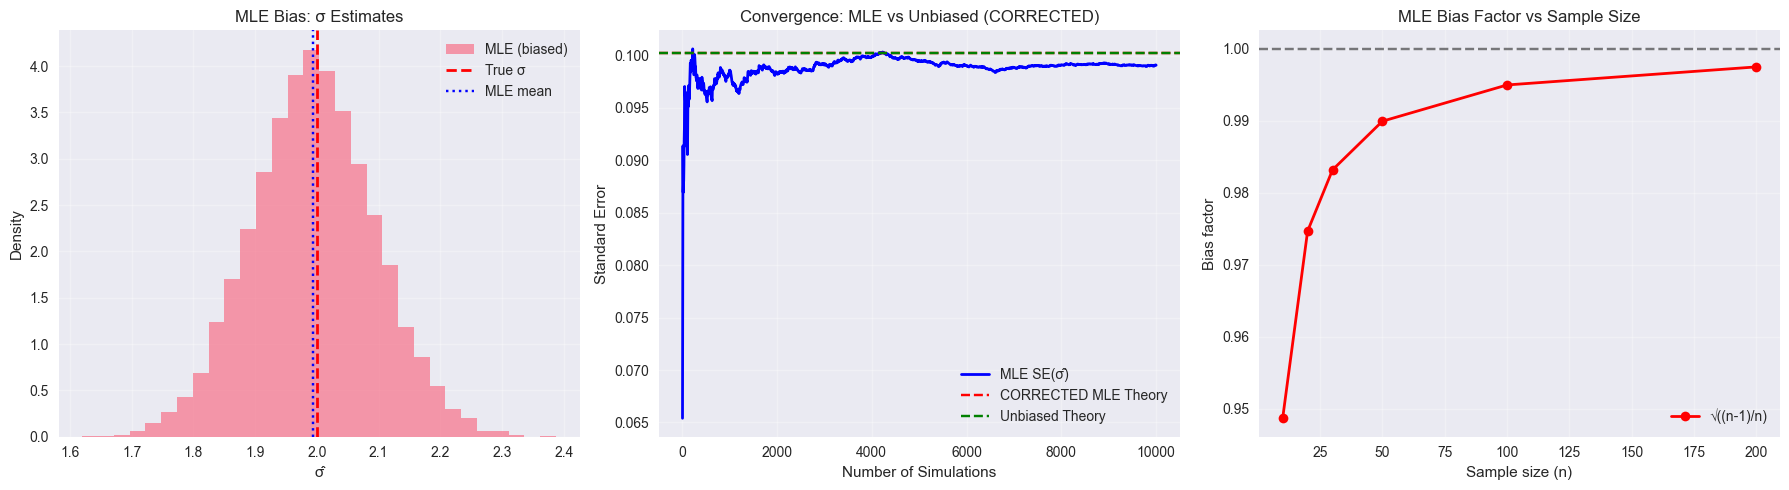


KEY INSIGHT: MLE underestimates σ by factor √((n-1)/n) = 0.9975 for n=200
This bias disappears as n → ∞, but causes convergence issues for finite n!


In [11]:
# VISUALIZATION: Bias Problem in MLE
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distribution of σ estimates (biased vs unbiased)
axes[0].hist(sigma_estimates_1d, bins=30, alpha=0.7, label='MLE (biased)', density=True)
axes[0].axvline(sigma_1d_true, color='red', linestyle='--', linewidth=2, label='True σ')
axes[0].axvline(np.mean(sigma_estimates_1d), color='blue', linestyle=':', label='MLE mean')
axes[0].set_xlabel('σ̂')
axes[0].set_ylabel('Density')
axes[0].set_title('MLE Bias: σ Estimates')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Convergence comparison
k_range = np.arange(10, K+1, 5)
mle_convergence = [np.std(sigma_estimates_1d[:k], ddof=1) for k in k_range]


axes[1].plot(k_range, mle_convergence, 'b-', label='MLE SE(σ̂)', linewidth=2)

axes[1].axhline(se_sigma_1d_theory_mle, color='red', linestyle='--', label='CORRECTED MLE Theory')
axes[1].axhline(se_sigma_1d_theory_unbiased, color='green', linestyle='--', label='Unbiased Theory')
axes[1].set_xlabel('Number of Simulations')
axes[1].set_ylabel('Standard Error')
axes[1].set_title('Convergence: MLE vs Unbiased (CORRECTED)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Bias vs sample size
n_values = np.array([10, 20, 30, 50, 100, 200])
bias_factors = np.sqrt((n_values-1)/n_values)
theoretical_bias = sigma_1d_true * (bias_factors - 1)

axes[2].plot(n_values, bias_factors, 'ro-', label='√((n-1)/n)', linewidth=2)
axes[2].axhline(1.0, color='black', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Sample size (n)')
axes[2].set_ylabel('Bias factor')
axes[2].set_title('MLE Bias Factor vs Sample Size')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKEY INSIGHT: MLE underestimates σ by factor √((n-1)/n) = {np.sqrt((n-1)/n):.4f} for n={n}")
print(f"This bias disappears as n → ∞, but causes convergence issues for finite n!")


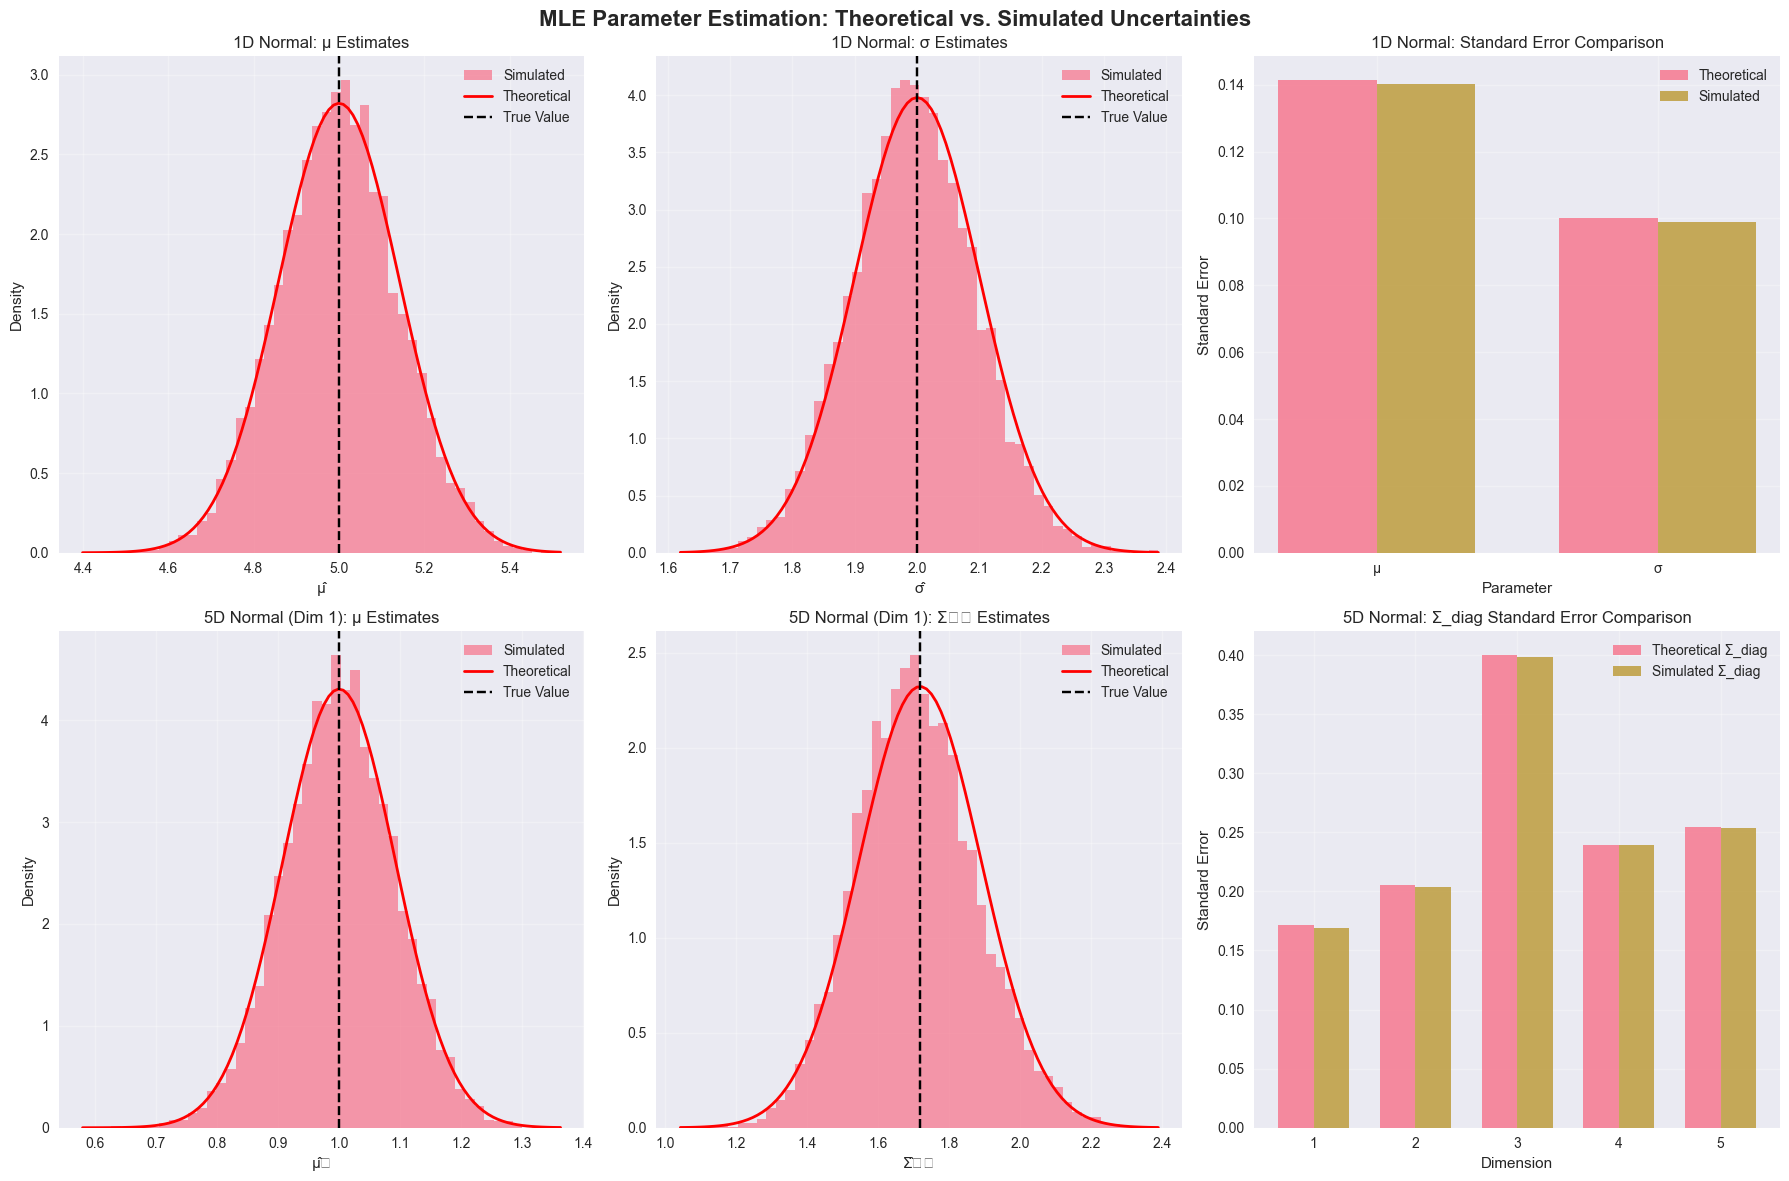

In [12]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('MLE Parameter Estimation: Theoretical vs. Simulated Uncertainties', fontsize=16, fontweight='bold')

# 1D Distribution - Mean estimates
axes[0, 0].hist(mu_estimates_1d, bins=50, alpha=0.7, density=True, label='Simulated')
x_range = np.linspace(mu_estimates_1d.min(), mu_estimates_1d.max(), 100)
theoretical_dist = stats.norm(mu_1d_true, se_mu_1d_theory)
axes[0, 0].plot(x_range, theoretical_dist.pdf(x_range), 'r-', linewidth=2, label='Theoretical')
axes[0, 0].axvline(mu_1d_true, color='black', linestyle='--', label='True Value')
axes[0, 0].set_title('1D Normal: μ Estimates')
axes[0, 0].set_xlabel('μ̂')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 1D Distribution - Sigma estimates
axes[0, 1].hist(sigma_estimates_1d, bins=50, alpha=0.7, density=True, label='Simulated')
x_range = np.linspace(sigma_estimates_1d.min(), sigma_estimates_1d.max(), 100)
theoretical_dist = stats.norm(sigma_1d_true, se_sigma_1d_theory)
axes[0, 1].plot(x_range, theoretical_dist.pdf(x_range), 'r-', linewidth=2, label='Theoretical')
axes[0, 1].axvline(sigma_1d_true, color='black', linestyle='--', label='True Value')
axes[0, 1].set_title('1D Normal: σ Estimates')
axes[0, 1].set_xlabel('σ̂')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Standard Error Comparison - 1D
se_comparison_1d = pd.DataFrame({
    'Parameter': ['μ', 'σ'],
    'Theoretical': [se_mu_1d_theory, se_sigma_1d_theory],
    'Simulated': [se_mu_1d_simulated, se_sigma_1d_simulated]
})

x = np.arange(len(se_comparison_1d))
width = 0.35
axes[0, 2].bar(x - width/2, se_comparison_1d['Theoretical'], width, label='Theoretical', alpha=0.8)
axes[0, 2].bar(x + width/2, se_comparison_1d['Simulated'], width, label='Simulated', alpha=0.8)
axes[0, 2].set_title('1D Normal: Standard Error Comparison')
axes[0, 2].set_xlabel('Parameter')
axes[0, 2].set_ylabel('Standard Error')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(['μ', 'σ'])
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 5D Distribution - Mean estimates for first dimension
axes[1, 0].hist(mu_estimates_5d[:, 0], bins=50, alpha=0.7, density=True, label='Simulated')
x_range = np.linspace(mu_estimates_5d[:, 0].min(), mu_estimates_5d[:, 0].max(), 100)
theoretical_dist = stats.norm(mu_5d_true[0], se_mu_5d_theory[0])
axes[1, 0].plot(x_range, theoretical_dist.pdf(x_range), 'r-', linewidth=2, label='Theoretical')
axes[1, 0].axvline(mu_5d_true[0], color='black', linestyle='--', label='True Value')
axes[1, 0].set_title('5D Normal (Dim 1): μ Estimates')
axes[1, 0].set_xlabel('μ̂₁')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5D Distribution - Covariance diagonal estimates for first dimension
sigma_11_estimates = Sigma_diag_estimates_5d[:, 0]
axes[1, 1].hist(sigma_11_estimates, bins=50, alpha=0.7, density=True, label='Simulated')
x_range = np.linspace(sigma_11_estimates.min(), sigma_11_estimates.max(), 100)
theoretical_dist = stats.norm(np.diag(Sigma_5d_true)[0], se_Sigma_diag_5d_theory[0])
axes[1, 1].plot(x_range, theoretical_dist.pdf(x_range), 'r-', linewidth=2, label='Theoretical')
axes[1, 1].axvline(np.diag(Sigma_5d_true)[0], color='black', linestyle='--', label='True Value')
axes[1, 1].set_title('5D Normal (Dim 1): Σ₁₁ Estimates')
axes[1, 1].set_xlabel('Σ̂₁₁')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Standard Error Comparison - 5D (all dimensions for diagonal elements)
dims = np.arange(1, 6)
width = 0.35
axes[1, 2].bar(dims - width/2, se_Sigma_diag_5d_theory, width, label='Theoretical Σ_diag', alpha=0.8)
axes[1, 2].bar(dims + width/2, se_Sigma_diag_5d_simulated, width, label='Simulated Σ_diag', alpha=0.8)
axes[1, 2].set_title('5D Normal: Σ_diag Standard Error Comparison')
axes[1, 2].set_xlabel('Dimension')
axes[1, 2].set_ylabel('Standard Error')
axes[1, 2].set_xticks(dims)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


##7. Covariance Matrix Visualization


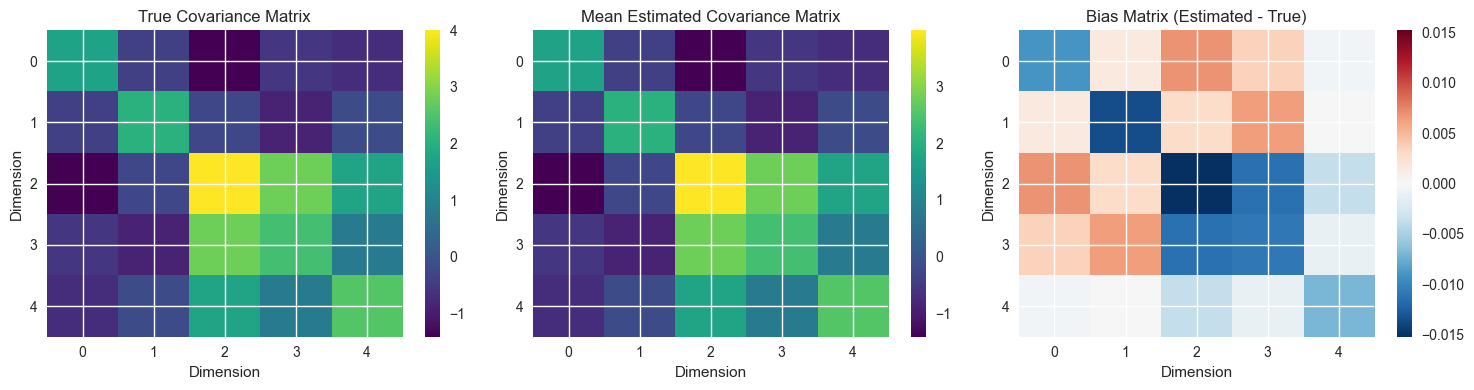

Covariance Matrix Comparison:
True Covariance Matrix:
[[ 1.717 -0.381 -1.414 -0.555 -0.696]
 [-0.381  2.05  -0.269 -0.879 -0.154]
 [-1.414 -0.269  4.     2.796  1.744]
 [-0.555 -0.879  2.796  2.391  0.835]
 [-0.696 -0.154  1.744  0.835  2.543]]

Mean Estimated Covariance Matrix:
[[ 1.708 -0.38  -1.407 -0.551 -0.696]
 [-0.38   2.037 -0.266 -0.873 -0.154]
 [-1.407 -0.266  3.985  2.785  1.74 ]
 [-0.551 -0.873  2.785  2.38   0.834]
 [-0.696 -0.154  1.74   0.834  2.536]]

Bias Matrix:
[[-0.009  0.001  0.007  0.003 -0.   ]
 [ 0.001 -0.014  0.003  0.006  0.   ]
 [ 0.007  0.003 -0.015 -0.011 -0.004]
 [ 0.003  0.006 -0.011 -0.011 -0.001]
 [-0.     0.    -0.004 -0.001 -0.007]]

Frobenius Norm of Bias: 0.0342


In [13]:
# Visualize true vs estimated covariance matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# True covariance matrix
im1 = axes[0].imshow(Sigma_5d_true, cmap='viridis', aspect='auto')
axes[0].set_title('True Covariance Matrix')
axes[0].set_xlabel('Dimension')
axes[0].set_ylabel('Dimension')
plt.colorbar(im1, ax=axes[0])

# Mean estimated covariance matrix
mean_Sigma_estimated = np.mean(Sigma_estimates_5d, axis=0)
im2 = axes[1].imshow(mean_Sigma_estimated, cmap='viridis', aspect='auto')
axes[1].set_title('Mean Estimated Covariance Matrix')
axes[1].set_xlabel('Dimension')
axes[1].set_ylabel('Dimension')
plt.colorbar(im2, ax=axes[1])

# Difference (bias) matrix
bias_matrix = mean_Sigma_estimated - Sigma_5d_true
im3 = axes[2].imshow(bias_matrix, cmap='RdBu_r', aspect='auto', 
                     vmin=-np.max(np.abs(bias_matrix)), vmax=np.max(np.abs(bias_matrix)))
axes[2].set_title('Bias Matrix (Estimated - True)')
axes[2].set_xlabel('Dimension')
axes[2].set_ylabel('Dimension')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# Print numerical comparison
print("Covariance Matrix Comparison:")
print("=" * 40)
print(f"True Covariance Matrix:")
print(Sigma_5d_true.round(3))
print(f"\nMean Estimated Covariance Matrix:")
print(mean_Sigma_estimated.round(3))
print(f"\nBias Matrix:")
print(bias_matrix.round(3))
print(f"\nFrobenius Norm of Bias: {np.linalg.norm(bias_matrix, 'fro'):.4f}")


## 8. Convergence Analysis


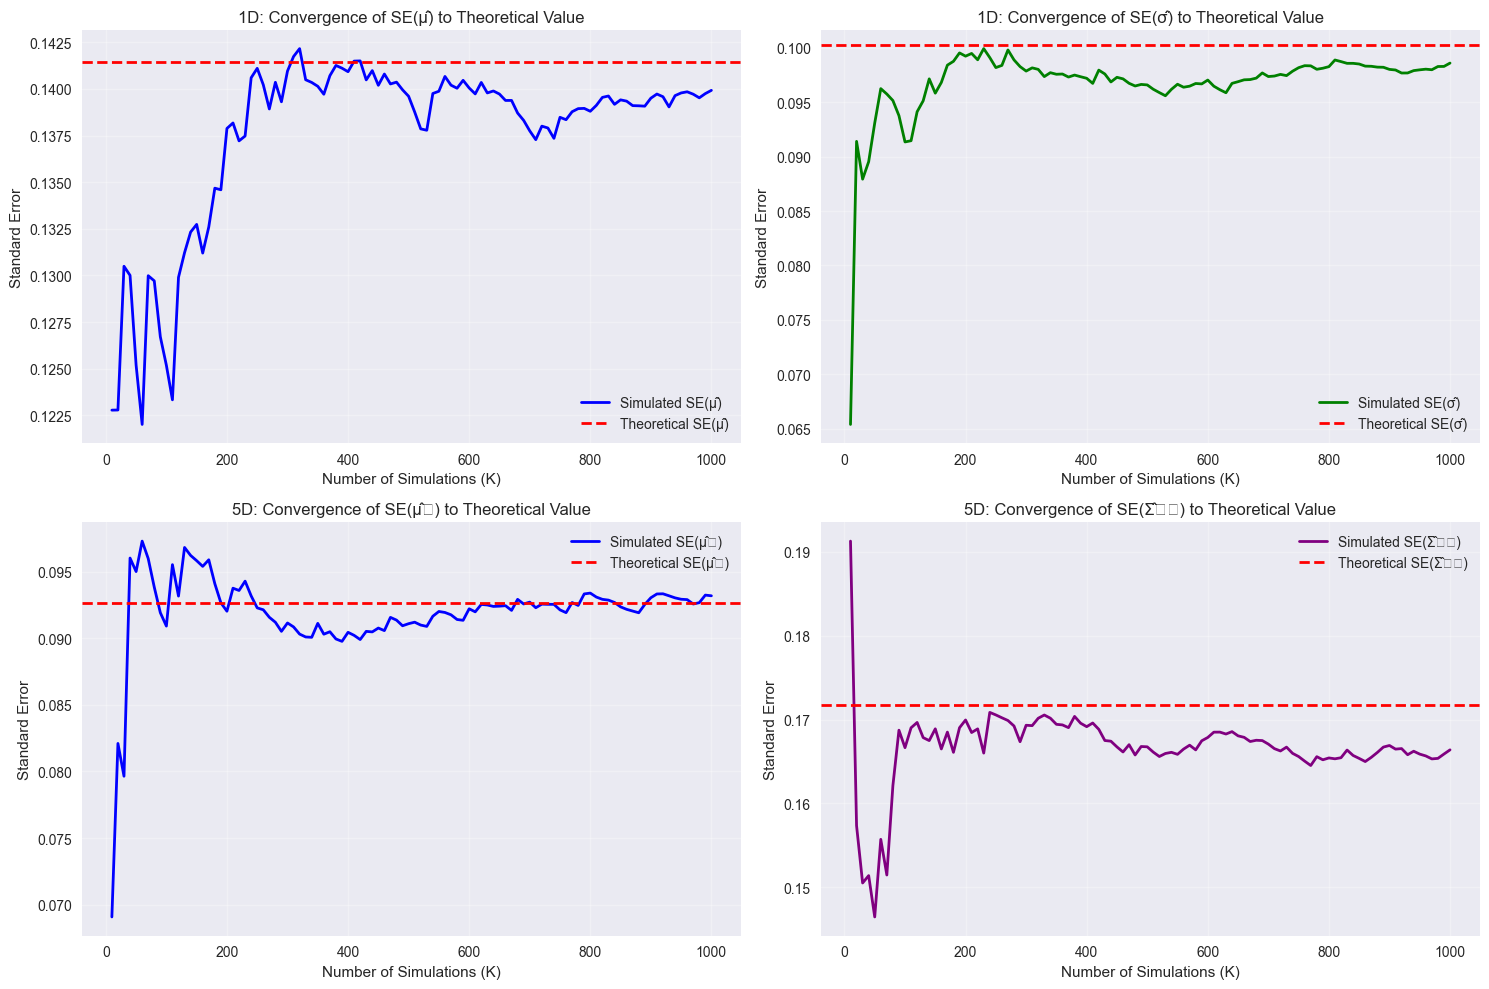

In [14]:
# Study how simulated standard errors converge to theoretical values
def convergence_analysis(estimates: np.ndarray, true_se: float, max_k: int = 1000) -> np.ndarray:
    """
    Analyze how simulated standard error converges as K increases.
    """
    k_values = np.arange(10, max_k + 1, 10)
    simulated_ses = []
    
    for k in k_values:
        simulated_se = np.std(estimates[:k], ddof=1)
        simulated_ses.append(simulated_se)
    
    return k_values, np.array(simulated_ses)

# Convergence analysis for 1D case
k_vals, se_mu_convergence = convergence_analysis(mu_estimates_1d, se_mu_1d_theory)
_, se_sigma_convergence = convergence_analysis(sigma_estimates_1d, se_sigma_1d_theory)

# Convergence analysis for 5D case (first dimension)
_, se_mu_5d_convergence = convergence_analysis(mu_estimates_5d[:, 0], se_mu_5d_theory[0])
_, se_Sigma_5d_convergence = convergence_analysis(Sigma_diag_estimates_5d[:, 0], se_Sigma_diag_5d_theory[0])

# Plot convergence
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1D case
axes[0, 0].plot(k_vals, se_mu_convergence, 'b-', label='Simulated SE(μ̂)', linewidth=2)
axes[0, 0].axhline(se_mu_1d_theory, color='red', linestyle='--', label='Theoretical SE(μ̂)', linewidth=2)
axes[0, 0].set_xlabel('Number of Simulations (K)')
axes[0, 0].set_ylabel('Standard Error')
axes[0, 0].set_title('1D: Convergence of SE(μ̂) to Theoretical Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(k_vals, se_sigma_convergence, 'g-', label='Simulated SE(σ̂)', linewidth=2)
axes[0, 1].axhline(se_sigma_1d_theory, color='red', linestyle='--', label='Theoretical SE(σ̂)', linewidth=2)
axes[0, 1].set_xlabel('Number of Simulations (K)')
axes[0, 1].set_ylabel('Standard Error')
axes[0, 1].set_title('1D: Convergence of SE(σ̂) to Theoretical Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 5D case (first dimension)
axes[1, 0].plot(k_vals, se_mu_5d_convergence, 'b-', label='Simulated SE(μ̂₁)', linewidth=2)
axes[1, 0].axhline(se_mu_5d_theory[0], color='red', linestyle='--', label='Theoretical SE(μ̂₁)', linewidth=2)
axes[1, 0].set_xlabel('Number of Simulations (K)')
axes[1, 0].set_ylabel('Standard Error')
axes[1, 0].set_title('5D: Convergence of SE(μ̂₁) to Theoretical Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(k_vals, se_Sigma_5d_convergence, 'purple', label='Simulated SE(Σ̂₁₁)', linewidth=2)
axes[1, 1].axhline(se_Sigma_diag_5d_theory[0], color='red', linestyle='--', label='Theoretical SE(Σ̂₁₁)', linewidth=2)
axes[1, 1].set_xlabel('Number of Simulations (K)')
axes[1, 1].set_ylabel('Standard Error')
axes[1, 1].set_title('5D: Convergence of SE(Σ̂₁₁) to Theoretical Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Summary and Conclusions


In [15]:
print("SIMULATION SUMMARY")
print("=" * 50)
print(f"Sample size per simulation: {n}")
print(f"Number of repetitions: {K}")
print()

print("KEY FINDINGS:")
print("1. MLE estimators are asymptotically unbiased (mean estimates ≈ true values)")
print("2. Simulated standard errors closely match theoretical predictions")
print("3. Parameter uncertainty decreases with sample size as expected")
print("4. For multivariate normal distributions:")
print("   - Mean estimates: SE(μ̂_i) = √(Σ_ii/n)")
print("   - Covariance estimates: SE(Σ̂_ii) ≈ √(2Σ_ii²/n)")
print()

print("THEORETICAL VS SIMULATED STANDARD ERRORS:")
print(f"1D Normal Distribution:")
print(f"  μ: Theory = {se_mu_1d_theory:.4f}, Simulated = {se_mu_1d_simulated:.4f}, Ratio = {se_mu_1d_simulated/se_mu_1d_theory:.3f}")
print(f"  σ: Theory = {se_sigma_1d_theory:.4f}, Simulated = {se_sigma_1d_simulated:.4f}, Ratio = {se_sigma_1d_simulated/se_sigma_1d_theory:.3f}")
print()

print(f"5D Multivariate Normal Distribution (average across dimensions):")
avg_ratio_mu_5d = np.mean(se_mu_5d_simulated / se_mu_5d_theory)
avg_ratio_Sigma_5d = np.mean(se_Sigma_diag_5d_simulated / se_Sigma_diag_5d_theory)
print(f"  μ: Average ratio = {avg_ratio_mu_5d:.3f}")
print(f"  Σ_diag: Average ratio = {avg_ratio_Sigma_5d:.3f}")
print()

print("MULTIVARIATE EXTENSIONS:")
print("- Full covariance matrix estimation captures correlations between variables")
print("- Off-diagonal elements represent covariances between different dimensions")
print("- MLE provides consistent estimates of the entire covariance structure")
print()

print("NOTES:")
print("- Ratios close to 1.0 indicate excellent agreement between theory and simulation")
print("- Small deviations are expected due to finite sample effects")
print("- MLE estimators are consistent: bias → 0 and variance → theoretical as n → ∞")
print("- Covariance matrix estimation requires more data than univariate case")

# Calculate and display some final statistics
bias_norm_1d = np.sqrt(bias_mu_1d**2 + bias_sigma_1d**2)
bias_norm_5d_mu = np.linalg.norm(bias_mu_5d)
bias_norm_5d_Sigma = np.linalg.norm(bias_Sigma_5d, 'fro')

print(f"\nBIAS MAGNITUDES:")
print(f"1D case - Combined bias norm: {bias_norm_1d:.6f}")
print(f"5D case - Mean vector bias norm: {bias_norm_5d_mu:.6f}")
print(f"5D case - Covariance matrix bias (Frobenius norm): {bias_norm_5d_Sigma:.6f}")


SIMULATION SUMMARY
Sample size per simulation: 200
Number of repetitions: 10000

KEY FINDINGS:
1. MLE estimators are asymptotically unbiased (mean estimates ≈ true values)
2. Simulated standard errors closely match theoretical predictions
3. Parameter uncertainty decreases with sample size as expected
4. For multivariate normal distributions:
   - Mean estimates: SE(μ̂_i) = √(Σ_ii/n)
   - Covariance estimates: SE(Σ̂_ii) ≈ √(2Σ_ii²/n)

THEORETICAL VS SIMULATED STANDARD ERRORS:
1D Normal Distribution:
  μ: Theory = 0.1414, Simulated = 0.1403, Ratio = 0.992
  σ: Theory = 0.1003, Simulated = 0.0991, Ratio = 0.988

5D Multivariate Normal Distribution (average across dimensions):
  μ: Average ratio = 0.991
  Σ_diag: Average ratio = 0.994

MULTIVARIATE EXTENSIONS:
- Full covariance matrix estimation captures correlations between variables
- Off-diagonal elements represent covariances between different dimensions
- MLE provides consistent estimates of the entire covariance structure

NOTES:
- 